##The definition of regression

Often we think about regression from the perspective of maximum-likelihood (or least squares). If we consider it from the Bayesian perspective we can get a more physical intuition for how we can undertake regression in the case of errors, and limits on the data.
<!-- TEASER_END -->

In a Bayesian approach, regression infers the expectation value of $y$ given $x$ (i.e., the conditional expectation value). 

> $p({\theta}|x_i, y_i,I) \propto p(x_i,y_i | {\theta}, I) \, p({\theta}, I)$

If we assume that the likelihood for a single data point is given by

> $p(y_i|x_i,{\theta}, I) = e(y_i|y)$

with $e(y_i|y)$ the probability of getting $y_i$ given the true value of $y$ (i.e. the error distribution). If the error distribution is Gaussian then,

> $p(y_i|x_i,{\theta}, I) =  {1 \over \sigma_i \sqrt{2\pi}} \, \exp{\left({-[y_i-f(x_i|{\theta})]^2 \over 2 \sigma_i^2}\right)}$

As we add points we multiply the likelihood surfaces together to improve the constraints

For linear regression the log likelihood is then

> $\ln \mathcal(L) \equiv \ln(({\theta}|x_i, y_i,I))  \propto \sum_{i=1}^N \left(\frac{-(y_i- (\theta_0 + \theta_1x_{i}))^2}{  2\sigma_i^2}\right)$
     
This is the log posterior (assuming the prior on the parameters is uniform)

Maximizing this is the same as minimizing the least squares 

<center><img src="figures/Hough.png" width=70%></center>

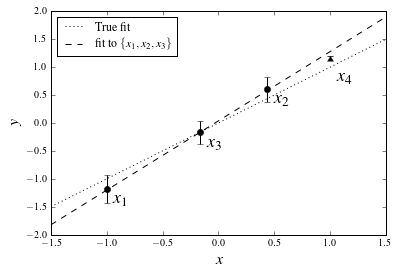

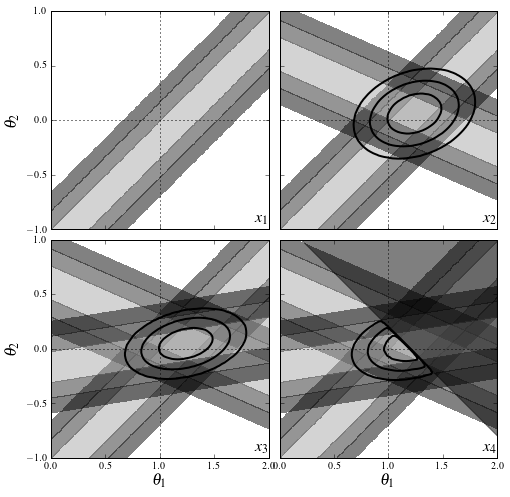

In [2]:
# Author: Jake VanderPlas <vanderplas@astro.washington.edu>
# License: BSD
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev

#------------------------------------------------------------
# Set up the data and errors
np.random.seed(13)
a = 1
b = 0

x = np.array([-1, 0.44, -0.16])
y = a * x + b
dy = np.array([0.25, 0.22, 0.2])

y = np.random.normal(y, dy)

# add a fourth point which is a lower bound
x4 = 1.0
y4 = a * x4 + b + 0.2

#------------------------------------------------------------
# Compute the likelihoods for each point
a_range = np.linspace(0, 2, 80)
b_range = np.linspace(-1, 1, 80)
logL = -((a_range[:, None, None] * x + b_range[None, :, None] - y) / dy) ** 2
sigma = [convert_to_stdev(logL[:, :, i]) for i in range(3)]

# compute best-fit from first three points
logL_together = logL.sum(-1)
i, j = np.where(logL_together == np.max(logL_together))
amax = a_range[i[0]]
bmax = b_range[j[0]]

#------------------------------------------------------------
# Plot the first figure: the points and errorbars
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

# Draw the true and best-fit lines
xfit = np.array([-1.5, 1.5])
ax1.plot(xfit, a * xfit + b, ':k', label='True fit')
ax1.plot(xfit, amax * xfit + bmax, '--k', label='fit to $\{x_1, x_2, x_3\}$')

ax1.legend(loc=2)

ax1.errorbar(x, y, dy, fmt='ok')
ax1.errorbar([x4], [y4], [[0.5], [0]], fmt='_k', lolims=True)

for i in range(3):
    ax1.text(x[i] + 0.05, y[i] - 0.3, "$x_{%i}$" % (i + 1), fontsize=18)
ax1.text(x4 + 0.05, y4 - 0.5, "$x_4$", fontsize=18)

ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)

ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-2, 2)

#------------------------------------------------------------
# Plot the second figure: likelihoods for each point
fig2 = plt.figure(figsize=(8, 8))
fig2.subplots_adjust(hspace=0.05, wspace=0.05)

# plot likelihood contours
for i in range(4):
    ax = fig2.add_subplot(221 + i)
    for j in range(min(i + 1, 3)):
        ax.contourf(a_range, b_range, sigma[j].T,
                    levels=(0, 0.683, 0.955, 0.997),
                    cmap=plt.cm.binary, alpha=0.5)

# plot the excluded area from the fourth point
axpb = a_range[:, None] * x4 + b_range[None, :]
mask = y4 < axpb
fig2.axes[3].fill_between(a_range, y4 - x4 * a_range, 2, color='k', alpha=0.5)

# plot ellipses
for i in range(1, 4):
    ax = fig2.axes[i]
    logL_together = logL[:, :, :i + 1].sum(-1)
    if i == 3:
        logL_together[mask] = -np.inf

    sigma_together = convert_to_stdev(logL_together)

    ax.contour(a_range, b_range, sigma_together.T,
               levels=(0.683, 0.955, 0.997),
               colors='k', linewidths=2)

# Label and adjust axes
for i in range(4):
    ax = fig2.axes[i]

    ax.text(1.98, -0.98, "$x_{%i}$" % (i + 1), ha='right', va='bottom',
            fontsize=16)

    ax.plot([0, 2], [0, 0], ':k', lw=1)
    ax.plot([1, 1], [-1, 1], ':k', lw=1)

    ax.set_xlim(0.001, 2)
    ax.set_ylim(-0.999, 1)

    if i in (1, 3):
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    if i in (0, 1):
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    if i in (0, 2):
        ax.set_ylabel(r'$\theta_2$', fontsize=16)
    if i in (2, 3):
        ax.set_xlabel(r'$\theta_1$', fontsize=16)
fig2.savefig("Hough.png")

plt.show()

## A matrix formalism provides a simplified approach to regression techniques

In general the simplest approach for regression is to think of it in terms of vectors and matrices

> $Y= M \theta$

$Y$ is an $N$-dimensional vector of values ${y_i}$,
>$Y=\left[
\begin{array}{c}
y_0\\
.\\
y_{N-1}
\end{array}
\right].
$

For the straight line $\theta$ is simply a two-dimensional
vector of regression coefficients,
>$
\theta=\left[
\begin{array}{c}
\theta_0\\
\theta_1
\end{array}
\right],
$

 $M$ is a called the design matrix
>$
M=\left[
\begin{array}{cc}
1 & x_0\\
.&.\\
1&x_{N-1}
\end{array}
\right]
$

the constant in the first column of $M$ captures the zeropoint in the regression 

For heteroscedastic undertainties we can define a covariance matrix

>$C=\left[
\begin{array}{cccc}
\sigma_{0}^2 & 0 & . & 0 \\
. & . & . & . \\
0 & 0 & . & \sigma_{N-1}^2 \\
\end{array}
\right]
$

and the maximum likelihood solution for the regression is

> $\theta = (M^T C^{-1} M)^{-1} (M^T C^{-1} Y)$

which minimizes the sum of squares and gives uncertainties on $\theta$ 

> $\Sigma_\theta =
\left[
\begin{array}{cc}
\sigma_{\theta_0}^2 & \sigma_{\theta_0\theta_1} \\
\sigma_{\theta_0\theta_1} & \sigma_{\theta_1}^2
\end{array}
\right]
= [M^T C^{-1} M]^{-1}.
$


With numpy it is straightforward to develop matrices and, as long as they can be inverted, calculate the  regression coefficients

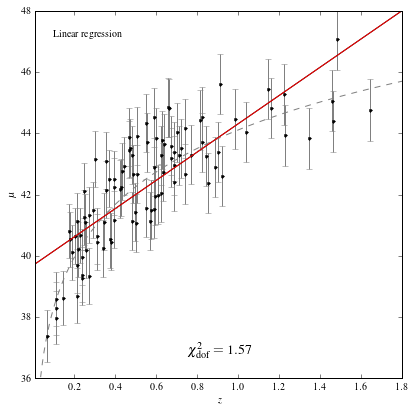

In [181]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z
from astroML.linear_model import LinearRegression, PolynomialRegression,\
    BasisFunctionRegression, NadarayaWatson

#------------------------------------------------------------
# Generate data
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)

cosmo = Cosmology()
z = np.linspace(0.01, 2, 1000)
mu_true = np.asarray(map(cosmo.mu, z))

n_constraints = 2

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    hspace=0.05, wspace=0.05)


#fit data using the design matrix formalism (linear then quadratic)
C = np.identity(len(z_sample))*(dmu*dmu)

M = np.column_stack((np.ones(len(z_sample)),z_sample))
#M = np.column_stack((np.ones(len(z_sample)),z_sample, z_sample**2)) # quadratic

A = np.dot(np.dot(M.transpose(),np.linalg.pinv(C)),M)
B = np.dot(np.dot(M.transpose(),np.linalg.pinv(C)),mu_sample)

theta = np.dot(np.linalg.pinv(A),B)
mu_out = theta[0] + theta[1]*z 
#mu_out = theta[0] + theta[1]*z + theta[2]*z*z # quadratic

ax = fig.add_subplot(111)

#fit data using standard package
clf = LinearRegression()
clf.fit(z_sample[:, None], mu_sample, dmu)
mu_sample_fit = clf.predict(z_sample[:, None])
mu_fit = clf.predict(z[:, None])
chi2_dof = (np.sum(((mu_sample_fit - mu_sample) / dmu) ** 2)
                    / (len(mu_sample) - n_constraints))


#plot the data
ax.plot(z, mu_fit, '-k')
ax.plot(z, mu_true, '--', c='gray')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

ax.text(0.5, 0.05, r"$\chi^2_{\rm dof} = %.2f$" % chi2_dof,
    ha='center', va='bottom', transform=ax.transAxes, fontsize=14)

ax.set_xlim(0.01, 1.8)
ax.set_ylim(36.01, 48)
ax.text(0.05, 0.95, 'Linear regression', ha='left', va='top',
                transform=ax.transAxes)

ax.set_ylabel(r'$\mu$')

ax.set_xlabel(r'$z$')

ax.plot(z, mu_out, '-k', color='red')

plt.show()

##Multivariate regression

Here we fit a hyperplane rather than a straight line

> $y_i =\theta_0 + \theta_1x_{i1} + \theta_2x_{i2} +
 \cdots +\theta_kx_{ik} + \epsilon_i$
 
 The design matrix, $M$, is now
 
> $M = \left(
\begin{array}{ccccccc}
1 & x_{01} & x_{02} & . & x_{0k}\\
1 & x_{11} & x_{12} & . & x_{1k}\\
. & . & . & .  & . \\
1 & x_{N1} & x_{N2} & . & x_{Nk}\\
\end{array}
\right)$

but the whole formalism is the same as before

##Basis function regression

If we consider a function in terms of the sum of bases (this can be polynomials, Gaussians, quadratics, cubics) then we can solve for the coefficients using regression. For polynomials,

> $M = \left(
\begin{array}{cccc}
1 & x_{0} & x_{0}^2 & x_{0}^3 \\
1 & x_{1} & x_{1}^2 & x_{1}^3\\
. & . & . & .  \\
1 & x_{N} & x_{N}^2 &  x_{N}^3\\
\end{array}
\right)$

but we could substitute $x_{0}^2$ etc for Gaussians (where we fix $\sigma$ and $\mu$ and fit for the amplitude) as long as the attribute we are fitting for is linear

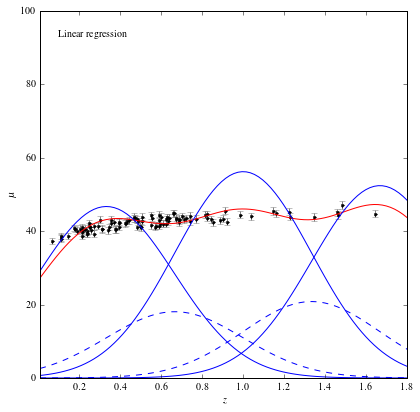

In [188]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z

#------------------------------------------------------------
# Generate data
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)

cosmo = Cosmology()
z = np.linspace(0.01, 2, 100)
mu_true = np.asarray(map(cosmo.mu, z))

#------------------------------------------------------------
# Define our Gaussians
nGaussians = 5
basis_mu = np.linspace(0., 2., nGaussians+2)[1:-1]
basis_sigma = 1. * (basis_mu[1] - basis_mu[0])
n_constraints = 2
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

#------------------------------------------------------------
M = np.zeros(shape=[nGaussians, z_sample.shape[0]])
for i in range(nGaussians):
    M[i] = gaussian_basis(z_sample, basis_mu[i], basis_sigma)

M = np.matrix(M).T
C = np.matrix(np.diagflat(dmu**2))
Y = np.matrix(mu_sample).T
coeff = (M.T * C.I * M).I * (M.T * C.I * Y)


# Plot the results
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    hspace=0.05, wspace=0.05)
ax = fig.add_subplot(111)

# draw the fit to the data
i=0
mu_fit = np.zeros(len(z))
for i in range(nGaussians):
    mu_fit += coeff[i,0]*gaussian_basis(z, basis_mu[i], basis_sigma)


ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)


ax.set_xlim(0.01, 1.8)
ax.set_ylim(0.,100.)
ax.text(0.05, 0.95, 'Linear regression', ha='left', va='top',
                transform=ax.transAxes)

ax.plot(z, mu_fit, '-k',color='red')
#plot the gaussians
for i in range(nGaussians):
    if (coeff[i,0] > 0.):
        ax.plot(z,coeff[i,0]*gaussian_basis(z, basis_mu[i], basis_sigma),color='blue')
    else:
        ax.plot(z,-coeff[i,0]*gaussian_basis(z, basis_mu[i], basis_sigma),color='blue',ls='--')

ax.set_ylabel(r'$\mu$')

ax.set_xlabel(r'$z$')


plt.show()


##Regularization

If we progressively increase the number of terms in the fit we reach a regime where we are overfitting the data (i.e. there are not enough degrees of freedom)

For cases where we are concerned with overfitting we can apply constraints (usually of smoothness, number of coefficients, size of coefficients).

> ($Y - M \theta)^T(Y- M \theta) + \lambda |\theta^T \theta|$

with $\lambda$ the regularization parameter

This leads to a solution for the parameters of the model

> $\theta = (M^T C^{-1} M + \lambda I)^{-1} (M^T C^{-1} Y)$

with $I$ the identity model

From the Bayesian perspective this is the same as applying a prior to the regression coefficients

> $p(\theta | I ) \propto \exp{\left(\frac{-(\lambda \theta^T \theta)}{2}\right)}$

which, when multiplied by the likelihood for regression, gives the same posterior as described above

##Ridge (Tikhonov) regularization

> $ |\theta |^2 < s$

penalty is on the sum of the squares of the regression coefficients

<center><img width=50%,  src="files/figures/ridge.png"></center>

This penalizes the size of the coefficients

Number of coefficient 100 100
Number of coefficient 100 100


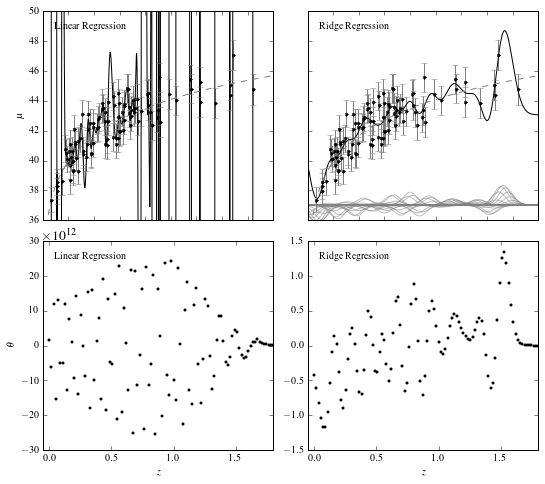

In [176]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z

import matplotlib

#----------------------------------------------------------------------
# generate data
np.random.seed(0)

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)
cosmo = Cosmology()

z = np.linspace(0.01, 2, 1000)
mu = np.asarray(map(cosmo.mu, z))


#------------------------------------------------------------
# Manually convert data to a gaussian basis
#  note that we're ignoring errors here, for the sake of example.
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

nGaussians=100
centers = np.linspace(0, 1.8, nGaussians)
widths = 3 * (centers[1] - centers[0])
X = gaussian_basis(z_sample[:, np.newaxis], centers, widths)

#------------------------------------------------------------
# Set up the figure to plot the results
fig = plt.figure(figsize=(12, 7))
fig.subplots_adjust(left=0.07, right=0.95,
                    bottom=0.08, top=0.95,
                    hspace=0.1, wspace=0.15)

lamVal=0.09
classifier = [LinearRegression, Ridge]
kwargs = [dict(), dict(alpha=lamVal), ]
labels = ['Linear Regression', 'Ridge Regression', ]

for i in range(2):
    clf = classifier[i](fit_intercept=True, **kwargs[i])
    clf.fit(X, mu_sample)
    w = clf.coef_
    fit = clf.predict(gaussian_basis(z[:, None], centers, widths))

    # plot fit
    ax = fig.add_subplot(231 + i)
    ax.xaxis.set_major_formatter(plt.NullFormatter())

    # plot curves for regularized fits
    if i == 0:
        ax.set_ylabel('$\mu$')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        curves = 37 + w * gaussian_basis(z[:, np.newaxis], centers, widths)
        curves = curves[:, abs(w) > 0.01]
        ax.plot(z, curves,
                c='gray', lw=1, alpha=0.5)

    ax.plot(z, fit, '-k')
    ax.plot(z, mu, '--', c='gray')
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
    ax.set_xlim(0.001, 1.8)
    ax.set_ylim(36, 50)
    ax.text(0.05, 0.95, labels[i],
            ha='left', va='top',
            transform=ax.transAxes)

    # plot weights
    ax = plt.subplot(234 + i)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.set_xlabel('$z$')
    if i == 0:
        ax.set_ylabel(r'$\theta$')
        w *= 1E-12
        ax.text(0, 1.01, r'$\rm \times 10^{12}$',
                transform=ax.transAxes, fontsize=14)
    ax.scatter(centers, w, s=9, lw=0, c='k')

    ax.set_xlim(-0.05, 1.8)

    #ax.set_ylim(-2, 4)

    ax.text(0.05, 0.95, labels[i],
            ha='left', va='top',
            transform=ax.transAxes)
    print "Number of coefficient",len(clf.coef_),len(np.where(np.abs(clf.coef_) > 0.)[0])

plt.show()

##Least absolute shrinkage and selection (Lasso) regularization

>$(Y - M \theta)^T(Y- M \theta) + \lambda |\theta|$


>$ |\theta | < s$

penalty is on the absolute values of the regression coefficients

<center><img src="files/figures/lasso.png"></center>

It not only weights the regression coefficients, it also imposes sparsity on the regression
model (i.e. the  penalty preferentially selects regions of likelihood space that coincide with one of the vertices within the region defined by the regularization)

This sets one (or more) of the model attributes to zero.  


Number of coefficient 100 100
Number of coefficient 100 12


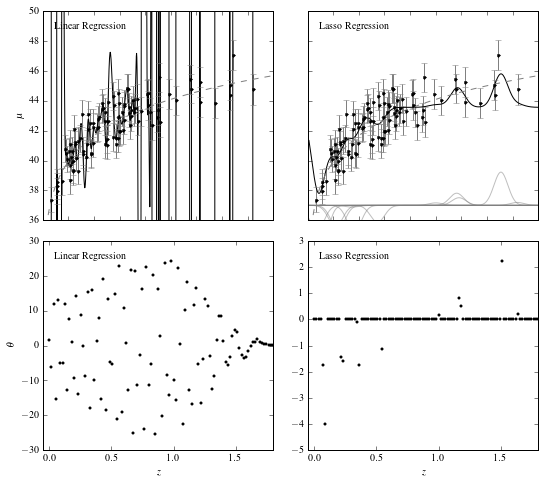

In [180]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z

import matplotlib

#----------------------------------------------------------------------
# generate data
np.random.seed(0)

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)
cosmo = Cosmology()

z = np.linspace(0.01, 2, 1000)
mu = np.asarray(map(cosmo.mu, z))


#------------------------------------------------------------
# Manually convert data to a gaussian basis
#  note that we're ignoring errors here, for the sake of example.
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

#nGaussians=10
nGaussians=100
centers = np.linspace(0, 1.8, nGaussians)
widths = 3 * (centers[1] - centers[0])
X = gaussian_basis(z_sample[:, np.newaxis], centers, widths)

#------------------------------------------------------------
# Set up the figure to plot the results
fig = plt.figure(figsize=(12, 7))
fig.subplots_adjust(left=0.07, right=0.95,
                    bottom=0.08, top=0.95,
                    hspace=0.1, wspace=0.15)

#alphaVal=0.000000000000000001
alphaVal=0.009
classifier = [LinearRegression, Lasso]
kwargs = [dict(), dict(alpha=alphaVal), ]
labels = ['Linear Regression', 'Lasso Regression', ]

for i in range(2):
    clf = classifier[i](fit_intercept=True, **kwargs[i])
    clf.fit(X, mu_sample)
    w = clf.coef_
    fit = clf.predict(gaussian_basis(z[:, None], centers, widths))

    # plot fit
    ax = fig.add_subplot(231 + i)
    ax.xaxis.set_major_formatter(plt.NullFormatter())

    # plot curves for regularized fits
    if i == 0:
        ax.set_ylabel('$\mu$')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        curves = 37 + w * gaussian_basis(z[:, np.newaxis], centers, widths)
        curves = curves[:, abs(w) > 0.01]
        ax.plot(z, curves,
                c='gray', lw=1, alpha=0.5)

    ax.plot(z, fit, '-k')
    ax.plot(z, mu, '--', c='gray')
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
    ax.set_xlim(0.001, 1.8)
    ax.set_ylim(36, 50)
    ax.text(0.05, 0.95, labels[i],
            ha='left', va='top',
            transform=ax.transAxes)

    # plot weights
    ax = plt.subplot(234 + i)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.set_xlabel('$z$')
    if i == 0:
        ax.set_ylabel(r'$\theta$')
        w *= 1E-12
#        ax.text(0, 1.01, r'$\rm \times 10^{12}$',
#                transform=ax.transAxes, fontsize=14)
    ax.scatter(centers, w, s=9, lw=0, c='k')

    ax.set_xlim(-0.05, 1.8)

    #ax.set_ylim(-2, 4)

    ax.text(0.05, 0.95, labels[i],
            ha='left', va='top',
            transform=ax.transAxes)
    print "Number of coefficient",len(clf.coef_),\
        len(np.where(np.abs(clf.coef_) > 0.)[0])

plt.show()

##How do we choose $\lambda$

Cross-validation (coming up later)

##Kernel (Nadaraya-Watson) Regression

Given a kernel $K(x_i,x)$ (e.g. a Gaussian or top-hat) at each point we estimate the function value by

>$f(x|K) = \frac{\sum_{i=1}^N K\left( \frac{||x_i-x||}{h} \right) y_i}
{\sum_{i=1}^N K\left( \frac{||x_i-x||}{h} \right)}$

a weighted average of $y$ (weighted by distance) with

>$w_i(x) = \frac{ K\left( \frac{||x_i-x||}{h} \right)}
{\sum_{i=1}^N K\left( \frac{||x_i-x||}{h} \right)}$

This locally weighted regression technique drives the regressed value to the nearest neighbor (when we have few points) which helps with extrapolation issues

Defining the correct bandwidth of the kernel is also done through cross-validation

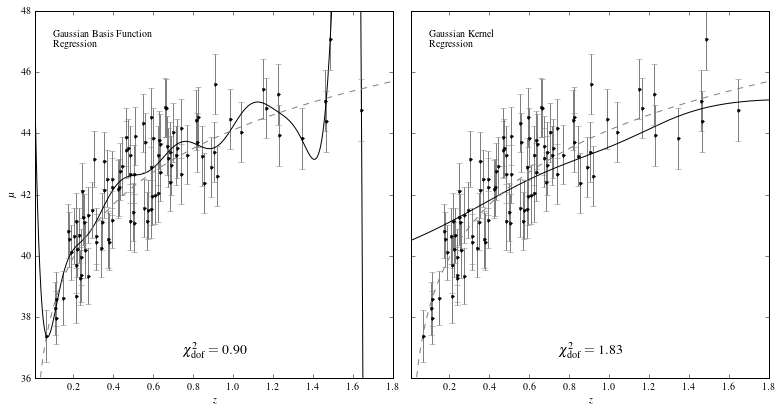

In [156]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z
from astroML.linear_model import LinearRegression, PolynomialRegression,\
    BasisFunctionRegression, NadarayaWatson

#------------------------------------------------------------
# Generate data
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)

cosmo = Cosmology()
z = np.linspace(0.01, 2, 1000)
mu_true = np.asarray(map(cosmo.mu, z))

#------------------------------------------------------------
# Define our classifiers
basis_mu = np.linspace(0, 2, 15)[:, None]
basis_sigma = 3 * (basis_mu[1] - basis_mu[0])

subplots = [121, 122, ]
classifiers = [BasisFunctionRegression('gaussian',
                                       mu=basis_mu, sigma=basis_sigma),
               NadarayaWatson('gaussian', h=0.25)]
text = ['Gaussian Basis Function\n Regression',
        'Gaussian Kernel\n Regression']

# number of constraints of the model.  Because
# Nadaraya-watson is just a weighted mean, it has only one constraint
n_constraints = [2, 5, len(basis_mu) + 1, 1]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    hspace=0.05, wspace=0.05)

for i in range(2):
    ax = fig.add_subplot(subplots[i])

    # fit the data
    clf = classifiers[i]
    clf.fit(z_sample[:, None], mu_sample, dmu)

    mu_sample_fit = clf.predict(z_sample[:, None])
    mu_fit = clf.predict(z[:, None])

    chi2_dof = (np.sum(((mu_sample_fit - mu_sample) / dmu) ** 2)
                / (len(mu_sample) - n_constraints[i]))

    ax.plot(z, mu_fit, '-k')
    ax.plot(z, mu_true, '--', c='gray')
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

    ax.text(0.5, 0.05, r"$\chi^2_{\rm dof} = %.2f$" % chi2_dof,
            ha='center', va='bottom', transform=ax.transAxes, fontsize=14)

    ax.set_xlim(0.01, 1.8)
    ax.set_ylim(36.01, 48)
    ax.text(0.05, 0.95, text[i], ha='left', va='top',
            transform=ax.transAxes)

    if i == 0):
        ax.set_ylabel(r'$\mu$')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())

    ax.set_xlabel(r'$z$')

plt.show()

##Locally Linear Regression (LOWESS or LOESS)

Similar to Kernel regression but we fit the local regression to the weighted points

> $\sum_{i=1}^N  K\left(\frac{||x-x_i||}{h}\right) \left( y_i - w(x) \, x_i \right)^2.$

LOWESS often uses the Kernel

> $K(x_i,x) = \left ( 1 - \left ( \frac{|x - x_i |}h{}\right )^3 \right )^3$




##Gaussian Proccess Regression

The "bible" for GP is Rasmussen and Williams "Gaussian Processes for Machine Learning" (2005)

A GP is a collection of random variables in a parameter space for which any subset can be defined by a joint Gaussian distribution. We can define them simply by the covariance function, e.g.

> $  {\rm Cov}(x_1, x_2; h) = \exp\left(\frac{-(x_1 - x_2)^2}{2 h^2}\right)$

For a given bandwidth we can define an infinite set of functions. We constrain these points by selecting those that pass though a given set of points (like our initial regression analysis)

> $p(f_j | \{x_i, y_i, \sigma_i\}, x_j^\ast)$


<img src="files/figures/gp.png">

For GP regression we want to estimate the value and variance of a new set of points given an input data set. This is equivalent to averaging over all functions that pass through our input data

The covariance matrix

> $  K = \begin{pmatrix}
    K_{11} & K_{12} \\
    K_{12}^T & K_{22}
  \end{pmatrix},
$

where $K_{11}$ is the covariance between the input points $x_i$ with
observational errors $\sigma_i^2$ added in quadrature to the diagonal,
$K_{12}$ is
the cross-covariance between the input points $x_i$ and the unknown points
$x^\ast_j$, and $K_{22}$ is the covariance between the unknown points
$x_j^\ast$.  Then for observed vectors $\vec{x}$ and $\vec{y}$, and a vector
of unknown points $\vec{x}^\ast$, it can be shown that the posterior is given by

>$  p(f_j | \{x_i, y_i, \sigma_i\}, x_j^\ast) = \mathcal{N}(\vec{\mu}, \Sigma)$

where

>$
\begin{eqnarray}
  \vec{\mu} &=& K_{12} K_{11}^{-1} \vec{y}, \\
  \Sigma &=& K_{22} - K_{12}^TK_{11}^{-1}K_{12}
\end{eqnarray}
$

$\mu_j$ gives the expected value $\bar{f}^\ast_j$ of the result, and
$\Sigma_{jk}$ gives the error covariance between any two unknown points.

_it gives the value and uncertainty of a predicted point_

Note that the physics of the underlying process enters through the assumed
form of the covariance function 



[[ 0.18093568]]


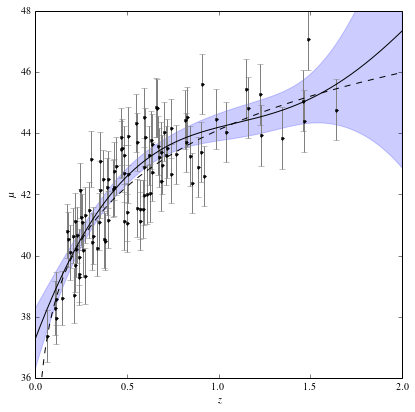

In [135]:
%matplotlib inline
# Author: Jake VanderPlas <vanderplas@astro.washington.edu>
# License: BSD
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcess

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z

#------------------------------------------------------------
# Generate data
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)

cosmo = Cosmology()
z = np.linspace(0.01, 2, 1000)
mu_true = np.asarray(map(cosmo.mu, z))

#------------------------------------------------------------
# fit the data
# Mesh the input space for evaluations of the real function,
# the prediction and its MSE
z_fit = np.linspace(0, 2, 1000)
gp = GaussianProcess(corr='squared_exponential', theta0=1e-1,
                     thetaL=1e-2, thetaU=1,
                     normalize=False,
                     nugget=(dmu / mu_sample) ** 2,
                     random_start=1)
gp.fit(z_sample[:, None], mu_sample)
y_pred, MSE = gp.predict(z_fit[:, None], eval_MSE=True)
sigma = np.sqrt(MSE)
print gp.theta_


#------------------------------------------------------------
# Plot the gaussian process
#  gaussian process allows computation of the error at each point
#  so we will show this as a shaded region
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
ax = fig.add_subplot(111)

ax.plot(z, mu_true, '--k')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', markersize=6)
ax.plot(z_fit, y_pred, '-k')
ax.fill_between(z_fit, y_pred - 1.96 * sigma, y_pred + 1.96 * sigma,
                alpha=0.2, color='b', label='95% confidence interval')

ax.set_xlabel('$z$')
ax.set_ylabel(r'$\mu$')

ax.set_xlim(0, 2)
ax.set_ylim(36, 48)

plt.show()


##Non-Linear Regression

The linear-regression techniques assume that the regression coefficients scale linearly. In many cases this is not true. 

Initial approaches to non-linear functions typically resort to transforming the data (e.g. logs and magnitudes). 

MCMC techniques can be used to sample the parameter space.

An alternate approach is to use the Levenberg-Marquardt (LM) algorithm to optimize the maximum
likelihood estimation. LM searches through a combination of gradient descent
and Gauss--Newton optimization. If we can express our
regression function as a Taylor series expansion then, to first order,
we can write

> $f(x_i|\theta) = f(x_i|\theta_0) + J d\theta$

where $\theta_0$ is an initial guess for the regression parameters,
$J$ is the Jacobian about this point ($J=\partial f(x_i|\theta)/ \partial
 \theta$), and $d\theta$ is a small change in the regression
parameters. 

LM minimizes the sum of square errors,

> $\sum_i (y_i- f(x_i|\theta_0) - J_i d\theta)^2$

for the perturbation $d\theta$. This results in an update relation for
$d\theta$ of

> $(J^TC^{-1}J + \lambda\ {\rm diag}(J^TC^{-1}J) )\,d\theta = J^TC^{-1}(Y-f(X|\theta))$

$\lambda$ term acts as a damping parameter  For
small $\lambda$ the relation approximates a Gauss-Newton method (i.e.,
it minimizes the parameters assuming the function is quadratic). For
large $\lambda$ the perturbation $d\theta$ follows the direction of
steepest descent. The diag$(J^TC^{-1}J)$ term, as opposed to the
identity matrix used in ridge regression, ensures that the update of
$d\theta$ is largest along directions where the gradient is smallest (which
improves convergence).


_In SciPy scipy.optimize.leastsq implements the LM algorithm_

## How do we deal with outliers: robust regression

The $L_2$ norm is sensitive to outliers (i.e. it squares the residuals). A number of approaches exist for correcting for outliers. These include "sigma-clipping", using interquartile ranges, taking the median of solutions of subsets of the data, and least trimmed squares (which searchs for the subset of points that minimizes $\sum_i^K (y_i - \theta_ix_i)^2$).

Other approaches include changing the loss function that is minimized such as the _Huber loss function_

> $
\sum_{i=1}^N e(y_i|y),
$

where

>$
e(t) = \left\{
\begin{array}{ll}
\frac{1}{2} t^2 & \mbox{if} \; |t| \leq c, \\
c|t| - \frac{1}{2} c^2 & \mbox{if} \; |t| \geq c,
\end{array}
\right )
$

this is continuous and differentiable and transitions to an $L_1$ norm for large excursions

Optimization terminated successfully.
         Current function value: 289.963723
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 43.439758
         Iterations: 59
         Function evaluations: 115
[   1.07674745  213.27350923]
[  1.96473118  70.00573832]


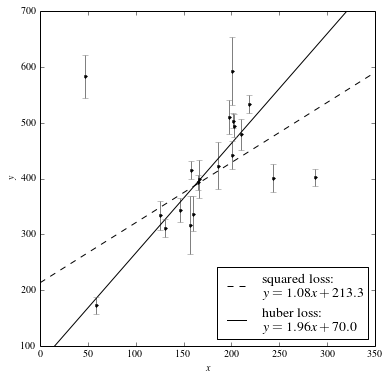

In [136]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from scipy import optimize
from astroML.datasets import fetch_hogg2010test

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']


# Define the standard squared-loss function
def squared_loss(m, b, x, y, dy):
    y_fit = m * x + b
    return np.sum(((y - y_fit) / dy) ** 2, -1)


# Define the log-likelihood via the Huber loss function
def huber_loss(m, b, x, y, dy, c=2):
    y_fit = m * x + b
    t = abs((y - y_fit) / dy)
    flag = t > c
    return np.sum((~flag) * (0.5 * t ** 2) - (flag) * c * (0.5 * c - t), -1)

f_squared = lambda beta: squared_loss(beta[0], beta[1], x=x, y=y, dy=dy)
f_huber = lambda beta: huber_loss(beta[0], beta[1], x=x, y=y, dy=dy, c=1)

#------------------------------------------------------------
# compute the maximum likelihood using the huber loss
beta0 = (2, 30)
beta_squared = optimize.fmin(f_squared, beta0)
beta_huber = optimize.fmin(f_huber, beta0)

print beta_squared
print beta_huber

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

x_fit = np.linspace(0, 350, 10)
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], '--k',
        label="squared loss:\n $y=%.2fx + %.1f$" % tuple(beta_squared))
ax.plot(x_fit, beta_huber[0] * x_fit + beta_huber[1], '-k',
        label="huber loss:\n $y=%.2fx + %.1f$" % tuple(beta_huber))
ax.legend(loc=4, prop=dict(size=14))

ax.errorbar(x, y, dy, fmt='.k', lw=1, ecolor='gray')

ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

## A Bayesian approach to outliers

Lets assume the data are drawn from two Gaussians error distribution (one for the function and the other for the outliers)

> $\begin{eqnarray}
&  p(\{y_i\}|\{x_i\}, \{\sigma_i\}, \theta_0, \theta_1, \mu_b, V_b, p_b)
  \propto \nonumber\\
&  \prod_{i=1}^{N} \bigg[
    \frac{1-p_b}{\sqrt{2\pi\sigma_i^2}}
      \exp\left(-\frac{(y_i - \theta_1 x_i - \theta_0)^2}
               {2 \sigma_i^2}\right)
    + \frac{p_b}{\sqrt{2\pi(V_b + \sigma_i^2)}}
    \exp\left(-\frac{(y_i - \mu_b)^2}{2(V_b + \sigma_i^2)}\right)
    \bigg].
\end{eqnarray}
$

$V_b$ is the variance of the outlier distribution. If we use MCMC we can marginalize over the nuisance  parameters $p_b$, $V_b$, $\mu_b$. We could also calculate the probability that a point is drawn from the outlier or "model" Gaussian.





 [-----------------100%-----------------] 25000 of 25000 complete in 7.4 sec

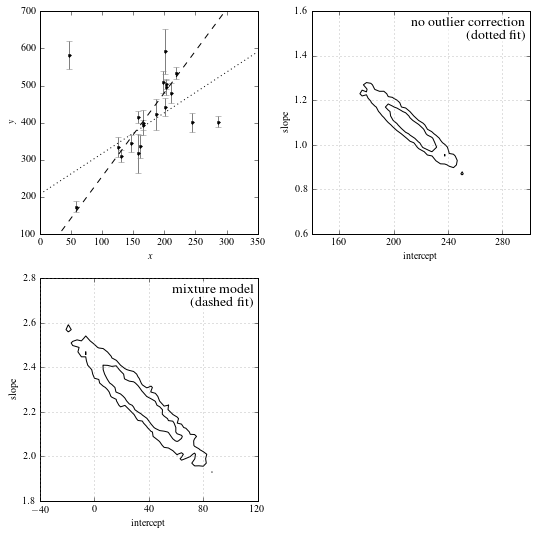

In [167]:
import numpy as np
from matplotlib import pyplot as plt
from astroML.datasets import fetch_hogg2010test
from astroML.plotting.mcmc import convert_to_stdev

# Hack to fix import issue in older versions of pymc
import scipy
import scipy.misc
scipy.derivative = scipy.misc.derivative
import pymc

np.random.seed(0)
pymc.numpy.random.seed(0)

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
xi = data['x']
yi = data['y']
dyi = data['sigma_y']


#----------------------------------------------------------------------
# First model: no outlier correction
# define priors on beta = (slope, intercept)
@pymc.stochastic
def beta_M0(value=np.array([2., 100.])):
    """Slope and intercept parameters for a straight line.
    The likelihood corresponds to the prior probability of the parameters."""
    slope, intercept = value
    prob_intercept = 1 + 0 * intercept
    # uniform prior on theta = arctan(slope)
    # d[arctan(x)]/dx = 1 / (1 + x^2)
    prob_slope = np.log(1. / (1. + slope ** 2))
    return prob_intercept + prob_slope


@pymc.deterministic
def model_M0(xi=xi, beta=beta_M0):
    slope, intercept = beta
    return slope * xi + intercept

y = pymc.Normal('y', mu=model_M0, tau=dyi ** -2,
                observed=True, value=yi)

M0 = dict(beta_M0=beta_M0, model_M0=model_M0, y=y)


#----------------------------------------------------------------------
# Second model: nuisance variables correcting for outliers
# This is the mixture model given in equation 17 in Hogg et al

# define priors on beta = (slope, intercept)
@pymc.stochastic
def beta_M1(value=np.array([2., 100.])):
    """Slope and intercept parameters for a straight line.
    The likelihood corresponds to the prior probability of the parameters."""
    slope, intercept = value
    prob_intercept = 1 + 0 * intercept
    # uniform prior on theta = arctan(slope)
    # d[arctan(x)]/dx = 1 / (1 + x^2)
    prob_slope = np.log(1. / (1. + slope ** 2))
    return prob_intercept + prob_slope


@pymc.deterministic
def model_M1(xi=xi, beta=beta_M1):
    slope, intercept = beta
    return slope * xi + intercept

# uniform prior on Pb, the fraction of bad points
Pb = pymc.Uniform('Pb', 0, 1.0, value=0.1)

# uniform prior on Yb, the centroid of the outlier distribution
Yb = pymc.Uniform('Yb', -10000, 10000, value=0)

# uniform prior on log(sigmab), the spread of the outlier distribution
log_sigmab = pymc.Uniform('log_sigmab', -10, 10, value=5)


@pymc.deterministic
def sigmab(log_sigmab=log_sigmab):
    return np.exp(log_sigmab)


# set up the expression for likelihood
def mixture_likelihood(yi, model, dyi, Pb, Yb, sigmab):
    """Equation 17 of Hogg 2010"""
    Vi = dyi ** 2
    Vb = sigmab ** 2

    root2pi = np.sqrt(2 * np.pi)

    L_in = (1. / root2pi / dyi
            * np.exp(-0.5 * (yi - model) ** 2 / Vi))

    L_out = (1. / root2pi / np.sqrt(Vi + Vb)
             * np.exp(-0.5 * (yi - Yb) ** 2 / (Vi + Vb)))

    return np.sum(np.log((1 - Pb) * L_in + Pb * L_out))

MixtureNormal = pymc.stochastic_from_dist('mixturenormal',
                                          logp=mixture_likelihood,
                                          dtype=np.float,
                                          mv=True)

y_mixture = MixtureNormal('y_mixture', model=model_M1, dyi=dyi,
                          Pb=Pb, Yb=Yb, sigmab=sigmab,
                          observed=True, value=yi)

M1 = dict(y_mixture=y_mixture, beta_M1=beta_M1, model_M1=model_M1,
          Pb=Pb, Yb=Yb, log_sigmab=log_sigmab, sigmab=sigmab)


#------------------------------------------------------------
# plot the data
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.1, top=0.95, hspace=0.2)

# first axes: plot the data
ax1 = fig.add_subplot(221)
ax1.errorbar(xi, yi, dyi, fmt='.k', ecolor='gray', lw=1)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

#------------------------------------------------------------
# Go through models; compute and plot likelihoods
models = [M0, M1]
linestyles = [':', '--', '-']
labels = ['no outlier correction\n(dotted fit)',
          'mixture model\n(dashed fit)',
          ]


x = np.linspace(0, 350, 10)

bins = [(np.linspace(140, 300, 51), np.linspace(0.6, 1.6, 51)),
        (np.linspace(-40, 120, 51), np.linspace(1.8, 2.8, 51)),
        (np.linspace(-40, 120, 51), np.linspace(1.8, 2.8, 51))]

for i, M in enumerate(models):
    S = pymc.MCMC(M)
    S.sample(iter=25000, burn=5000)
    trace = S.trace('beta_M%i' % i)

    H2D, bins1, bins2 = np.histogram2d(trace[:, 0], trace[:, 1], bins=50)
    w = np.where(H2D == H2D.max())

    # choose the maximum posterior slope and intercept
    slope_best = bins1[w[0][0]]
    intercept_best = bins2[w[1][0]]

    # plot the best-fit line
    ax1.plot(x, intercept_best + slope_best * x, linestyles[i], c='k')

    # For the model which identifies bad points,
    # plot circles around points identified as outliers.
    if i == 2:
        qi = S.trace('qi')[:]
        Pi = qi.astype(float).mean(0)
        outlier_x = xi[Pi < 0.32]
        outlier_y = yi[Pi < 0.32]
        ax1.scatter(outlier_x, outlier_y, lw=1, s=400, alpha=0.5,
                    facecolors='none', edgecolors='red')

    # plot the likelihood contours
    ax = plt.subplot(222 + i)

    H, xbins, ybins = np.histogram2d(trace[:, 1], trace[:, 0], bins=bins[i])
    H[H == 0] = 1E-16
    Nsigma = convert_to_stdev(np.log(H))

    ax.contour(0.5 * (xbins[1:] + xbins[:-1]),
               0.5 * (ybins[1:] + ybins[:-1]),
               Nsigma.T, levels=[0.683, 0.955], colors='black')

    ax.set_xlabel('intercept')
    ax.set_ylabel('slope')
    ax.grid(color='gray')
    ax.xaxis.set_major_locator(plt.MultipleLocator(40))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))

    ax.text(0.98, 0.98, labels[i], ha='right', va='top', fontsize=14,
            bbox=dict(fc='w', ec='none', alpha=0.5),
            transform=ax.transAxes)
    ax.set_xlim(bins[i][0][0], bins[i][0][-1])
    ax.set_ylim(bins[i][1][0], bins[i][1][-1])

ax1.set_xlim(0, 350)
ax1.set_ylim(100, 700)

plt.show()

## The full monty: uncertainties all round

In almost all real-world applications, the assumption that one variable (the independent variable) is essentially free
from any uncertainty is not valid. Imagine the "true" relation,

>$
y^*_i=\theta_0 + \theta_1x^*_{i}.
$

Now we make measurements in $x$, and $y$ which are noisy (Gaussian noise)

>$
x_i = x^*_i + \delta_i,\\
y_i = y^* + \epsilon_i,
$

Solving for $y$ we get
>$
      \hat{y}=  \theta_0 + \theta_1 (x_i - \delta_i) +\epsilon_i.
$

$\hat{y}$ depends on the noise in $x$

Optimization terminated successfully.
         Current function value: 7725.143767
         Iterations: 76
         Function evaluations: 143


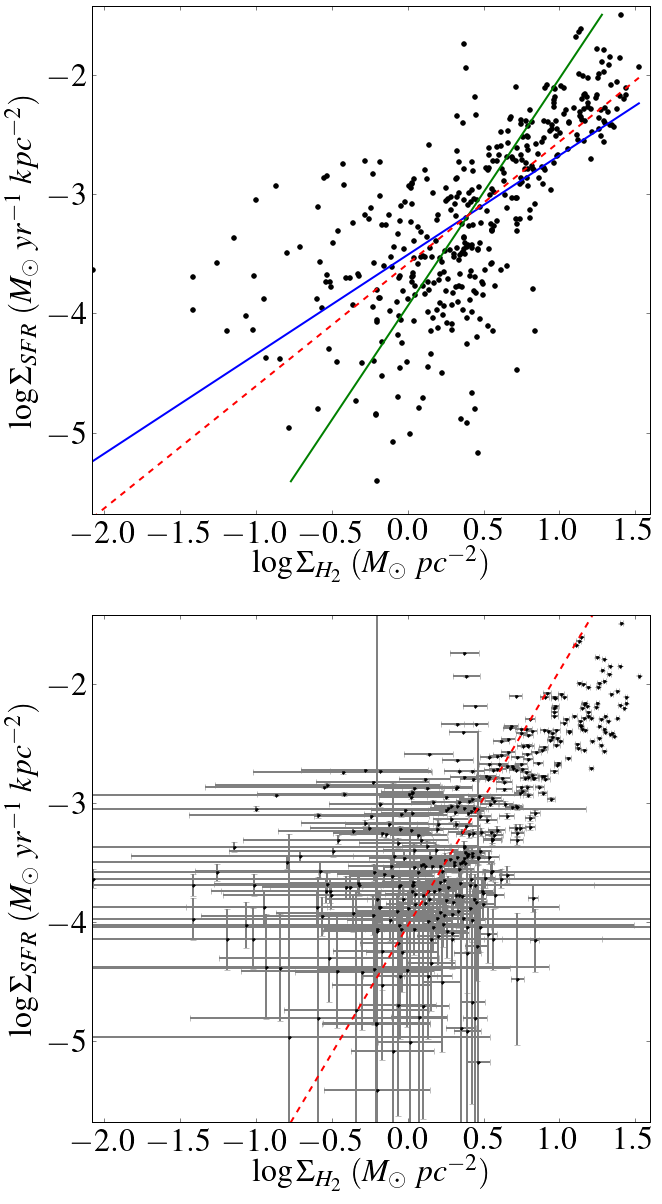

In [163]:
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.cm as cm
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LinearRegression as LR
from astroML.plotting import setup_text_plots

from astroML.linear_model import TLS_logL
#from astroML.plotting.mcmc import convert_to_stdev

#NOTE NEED TO VERIFY THAT ERRORS ARE BEING PROPAGATED PROPERLY
def convert_to_stdev(logL):
    """
    Given a grid of log-likelihood values, convert them to cumulative
    standard deviation.  This is useful for drawing contours from a
    grid of likelihoods.
    """
    sigma = np.exp(logL)
    shape = sigma.shape
    sigma = sigma.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(sigma)[::-1]
    i_unsort = np.argsort(i_sort)

    sigma_cumsum = sigma[i_sort].cumsum()
    sigma_cumsum /= sigma_cumsum[-1]

    return sigma_cumsum[i_unsort].reshape(shape)


# translate between typical slope-intercept representation, and the normal vector representation
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b


def get_beta(m, b):
    denom = (1 + m * m)
    return np.array([-b * m / denom, b / denom])


# compute the ellipse pricipal axes and rotation from covariance
def get_principal(sigma_x, sigma_y, rho_xy):
    sigma_xy2 = rho_xy * sigma_x * sigma_y

    alpha = 0.5 * np.arctan2(2 * sigma_xy2,
                             (sigma_x ** 2 - sigma_y ** 2))
    tmp1 = 0.5 * (sigma_x ** 2 + sigma_y ** 2)
    tmp2 = np.sqrt(0.25 * (sigma_x ** 2 - sigma_y ** 2) ** 2 + sigma_xy2 ** 2)

    return np.sqrt(tmp1 + tmp2), np.sqrt(tmp1 - tmp2), alpha


# plot ellipses
def plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, factor=2, ax=None):
    if ax is None:
        ax = plt.gca()

    sigma1, sigma2, alpha = get_principal(sigma_x, sigma_y, rho_xy)

    for i in range(len(x)):
        ax.add_patch(Ellipse((x[i], y[i]),
                             factor * sigma1[i], factor * sigma2[i],
                             alpha[i] * 180. / np.pi,
                             fc='none', ec='k'))


def main ():
    # read data and select training and cross validation sample
    x,dx,y,dy = np.loadtxt("X_Y.clean.txt", skiprows=1, unpack=True)
    dxy=np.zeros(len(x))

    # define classifiers
    n_constraints = [2,]

    # set plots
    fig = plt.figure(figsize=(10, 20))
    ax = fig.add_subplot(211)
    ax.scatter(x, y,c='black')
    xSample = np.linspace(x.min(), x.max(), 1000)

    # generate fits: y given x with no errors scikit-learn
    clf = LR(fit_intercept=True)
    clf.fit(x[:, None], y)
    yFit = clf.predict(x[:, None])
    ySample = clf.predict(xSample[:, None])

    chi2_dof = (np.sum(((yFit - y)) ** 2)
                / (len(yFit) - n_constraints[0]))

    ax.plot(xSample, ySample, '-k',color='b', lw=2)
    b11, b12 = clf.intercept_, clf.coef_       

    # generate fits: x given y with no errors scikit-learn
    ySample = np.linspace(y.min(), y.max(), 1000)
    clf.fit(y[:, None], x)
    xFit = clf.predict(y[:, None])
    xSample = clf.predict(ySample[:, None])
    chi2_dof = (np.sum(((xFit - x) / dx) ** 2)
                / (len(xFit) - n_constraints[0]))
    ax.plot(xSample, ySample, '-k',color='g',lw=2)
    b21, b22 = -clf.intercept_/clf.coef_, 1./clf.coef_


    ax.set_xlim(x.min()/1.05,x.max()*1.05)
    ax.set_ylim(y.min()*1.05,y.max()/1.05)
    ax.set_xlabel("$\log \Sigma_{H_2}\ (M_\odot\ pc^{-2})$")
    ax.set_ylabel("$\log \Sigma_{SFR}\ (M_\odot\ yr^{-1}\ kpc^{-2})$")


    #geometric mean
    b32 = (b12 + b22)**-1 * (b12*b22 - 1. + np.sqrt((1+b12**2)*(1+b22)))
    b31 = y.mean() - x.mean()*b32 
    xSample = np.linspace(x.min(), x.max(), 1000)
    ySample = b32*xSample + b31
    ax.plot(xSample, ySample, '--k',color='r', lw=2)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(32)
  
    plt.savefig("stdFit.png")

    ax = fig.add_subplot(212)
    #Hogg approach
    #------------------------------------------------------------
    # Find best-fit parameters
    X = np.vstack((x, y)).T
    dX = np.zeros((len(x), 2, 2))

    dX[:, 0, 0] = dx ** 2
    dX[:, 1, 1] = dy ** 2
    dX[:, 0, 1] = dX[:, 1, 0] = dxy * dx * dy

    min_func = lambda beta: -TLS_logL(beta, X, dX)
    beta_fit = optimize.fmin(min_func,
                             x0=[1., 0])

    ax.errorbar(x, y, dy, dx, fmt='.k', ecolor='gray', lw=2)
    ax.set_xlim(x.min()/1.05,x.max()*1.05)
    ax.set_ylim(y.min()*1.05,y.max()/1.05)
    ax.set_xlabel("$\log \Sigma_{H_2}\ (M_\odot\ pc^{-2})$")
    ax.set_ylabel("$\log \Sigma_{SFR}\ (M_\odot\ yr^{-1}\ kpc^{-2})$")

    m_fit, b_fit = get_m_b(beta_fit)
    x_fit = np.linspace(x.min(), x.max(), 10)
    b = y.mean() - x.mean()*m_fit

    ax.plot(x_fit, m_fit * x_fit + b, '--k',color='r', lw=2)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(32)
  
    plt.savefig("totalFit.png")



    plt.show()

if __name__ == '__main__':
    main()


##Cross-validation

As the complexity of a model increases, the best-fit curve matches
the data points more and more closely (the MSE can be reduced to zero). This does not, however,
result in a better fit to the data. The model suffers from high
variance; it overfits the data (a small perturbation of one of the training points
can change the best-fit model by a large magnitude).  In a high-variance
model, the fit varies strongly depending on the exact set or subset of data
used to fit it.

If we can differentiate between the data used to constrain the model (training set: 50-70% of sample),  a set of data we can validate the model against (cross-validation set: 15-25%) and a test set (15-25%). 

The training set is used to determine the parameters of a given model.
The cross-validation set is used to evaluate the cross-validation error
$\epsilon_{\rm cv}$ of the model. Because this cross-validation set was not used to construct the fit, the cross-validation error will be large for a high-bias (overfit) model. Once this model is determined, the test error is evaluated using the test set,  This test error gives an estimate of the reliability of the model.

$\theta = \{\theta_0, \theta_1, \ldots, \theta_d\}$.  We will denote
by $\theta^{(n)} = \{\theta_0^{(n)}, \theta_1^{(n)}, \ldots, \theta_d^{(n)}\}$
the model parameters which best fit the first $n$ points
of the training data: here $n \le N_{\rm train}$, where $N_{\rm train}$
is the total number of
training points.  The truncated training error for $\theta^{(n)}$ is given by


>$
\epsilon_{\rm tr}^{(n)} = \sqrt{\frac{1}{n}\sum_{i=1}^n
  \left[y_i - \sum_{m=0}^d \theta_0^{(n)}x_i^m\right]}.
$

training error $\epsilon_{\rm tr}^{(n)}$ is evaluated using only the
$n$ points on which the model parameters $\theta^{(n)}$ were trained

>$\epsilon_{\rm cv}^{(n)} = \sqrt{\frac{1}{n}\sum_{i=1}^{N_{\rm cv}}
  \left[y_i - \sum_{m=0}^d \theta_0^{(n)}x_i^m\right]}$
  
  sum over _all_ of the cross-validation points

//anaconda/python.app/Contents/lib/python2.7/site-packages/numpy/lib/polynomial.py:585: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
//anaconda/python.app/Contents/lib/python2.7/site-packages/numpy/lib/polynomial.py:585: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
//anaconda/python.app/Contents/lib/python2.7/site-packages/numpy/lib/polynomial.py:585: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


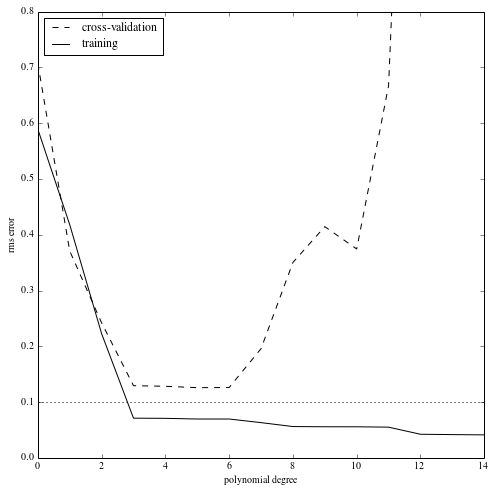

In [138]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.patches import FancyArrow


#------------------------------------------------------------
# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

#------------------------------------------------------------
# select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

#------------------------------------------------------------
# Select the cross-validation points
np.random.seed(1)
x_cv = 3 * np.random.random(20)
y_cv = func(x_cv)

x_fit = np.linspace(0, 3, 1000)



#------------------------------------------------------------
# Third figure: plot errors as a function of polynomial degree d
d = np.arange(0, 21)
training_err = np.zeros(d.shape)
crossval_err = np.zeros(d.shape)

fig = plt.figure(figsize=(8, 8))
for i in range(len(d)):
    p = np.polyfit(x, y, d[i])
    training_err[i] = np.sqrt(np.sum((np.polyval(p, x) - y) ** 2)
                              / len(y))
    crossval_err[i] = np.sqrt(np.sum((np.polyval(p, x_cv) - y_cv) ** 2)
                              / len(y_cv))


ax = fig.add_subplot(111)
ax.plot(d, crossval_err, '--k', label='cross-validation')
ax.plot(d, training_err, '-k', label='training')
ax.plot(d, 0.1 * np.ones(d.shape), ':k')

ax.set_xlim(0, 14)
ax.set_ylim(0, 0.8)

ax.set_xlabel('polynomial degree')
ax.set_ylabel('rms error')
ax.legend(loc=2)



plt.show()

_Twofold cross-validation_

Above, we split the data into a training set $d_1$, a cross-validation
set $d_2$, and a test set $d_0$.  Our simple tests involved training
the model on $d_0$ and cross-validating the model on $d_1$.  In twofold
cross-validation, this process is repeated, training the model on $d_1$ and
cross-validating the model on $d_0$.  The training error and cross-validation
error are computed from the mean of the errors in each fold.
This leads to more robust determination
of the cross-validation error for smaller data sets.

_$K$-fold cross-validation_

A generalization of twofold cross-validation is $K$-fold cross-validation.
Here we split the data into $K + 1$ sets: the test set $d_0$, and
the cross-validation sets  $d_1, d_2, \ldots, d_K$.  We train $K$ different
models, each time leaving out a single subset to measure the cross-validation
error.  The final training error and cross-validation error can be computed
using the mean or median of the set of results.  The median can be a better
statistic than the mean in cases where the subsets $d_i$ contain few
points.

_Leave-one-out cross-validation_

At the extreme of $K$-fold cross-validation is leave-one-out cross-validation.
This is essentially the same as $K$-fold cross-validation, but this  time
our sets $d_1, d_2, \ldots, d_K$ have only one data point each.  That is, we
repeatedly train the model, leaving out only a single point to estimate the
cross-validation error.  Again, the final training error and cross-validation
error are estimated using the mean or median of the individual trials.
This can be useful when the size of the data set is
very small, so that significantly reducing the number of data points leads
to much different model characteristics.